# Sobel Edge Detection Filter

This notebook demonstrates how to use PYNQ to communicate with the hardware accelerated Sobel Edge Detection filter.

We are using a pre-built bitstream here. You can re-create this by generating a System Generator IP with the `axi_stream_sobel_filter.slx` model and then including this IP in a Vivado project. This is an extremely similar process to steps detailed on ["PYNQ 4: Creating a Custom Overlay with a Streaming IP"](https://classes.myplace.strath.ac.uk/mod/resource/view.php?id=997323) on Myplace. Try to match the IP integrator diagram shown below. (You can find the image in the `./assets/` folder if you want to zoom in.)

![IP Integrator diagram for the Sobel Filter example](./assets/vivado_project.png)
  
  > The names of the DMA IP cores are important here as we use these names from Python later on!

## Handling images in Python

Before we start looking at any hardware acceleration, let's just make sure we can parse and display images in Python. Start by importing some useful libraries:

  1. `PIL` (Python Image Library) for most of the image handling
  2. `Numpy` for support for fast, statically-typed, fixed-length buffers. This is useful for performance when working with large images, but also for streaming these images to and from fixed-point hardware.
  

In [1]:
from PIL import Image
import numpy as np

Let's start by reading a JPG file from the SD card with the `Image.open(...)` function. We've included a picture of Marcus the cat in this repo for you 😻.

In [2]:
image_raw = Image.open("assets/cat.jpg")

As a sanity check, let's immediately try to display the image. If we end a cell with a line containing a variable name, Jupyter will display the contents for us. This also works for images, so let's try displaying `image_raw` now.

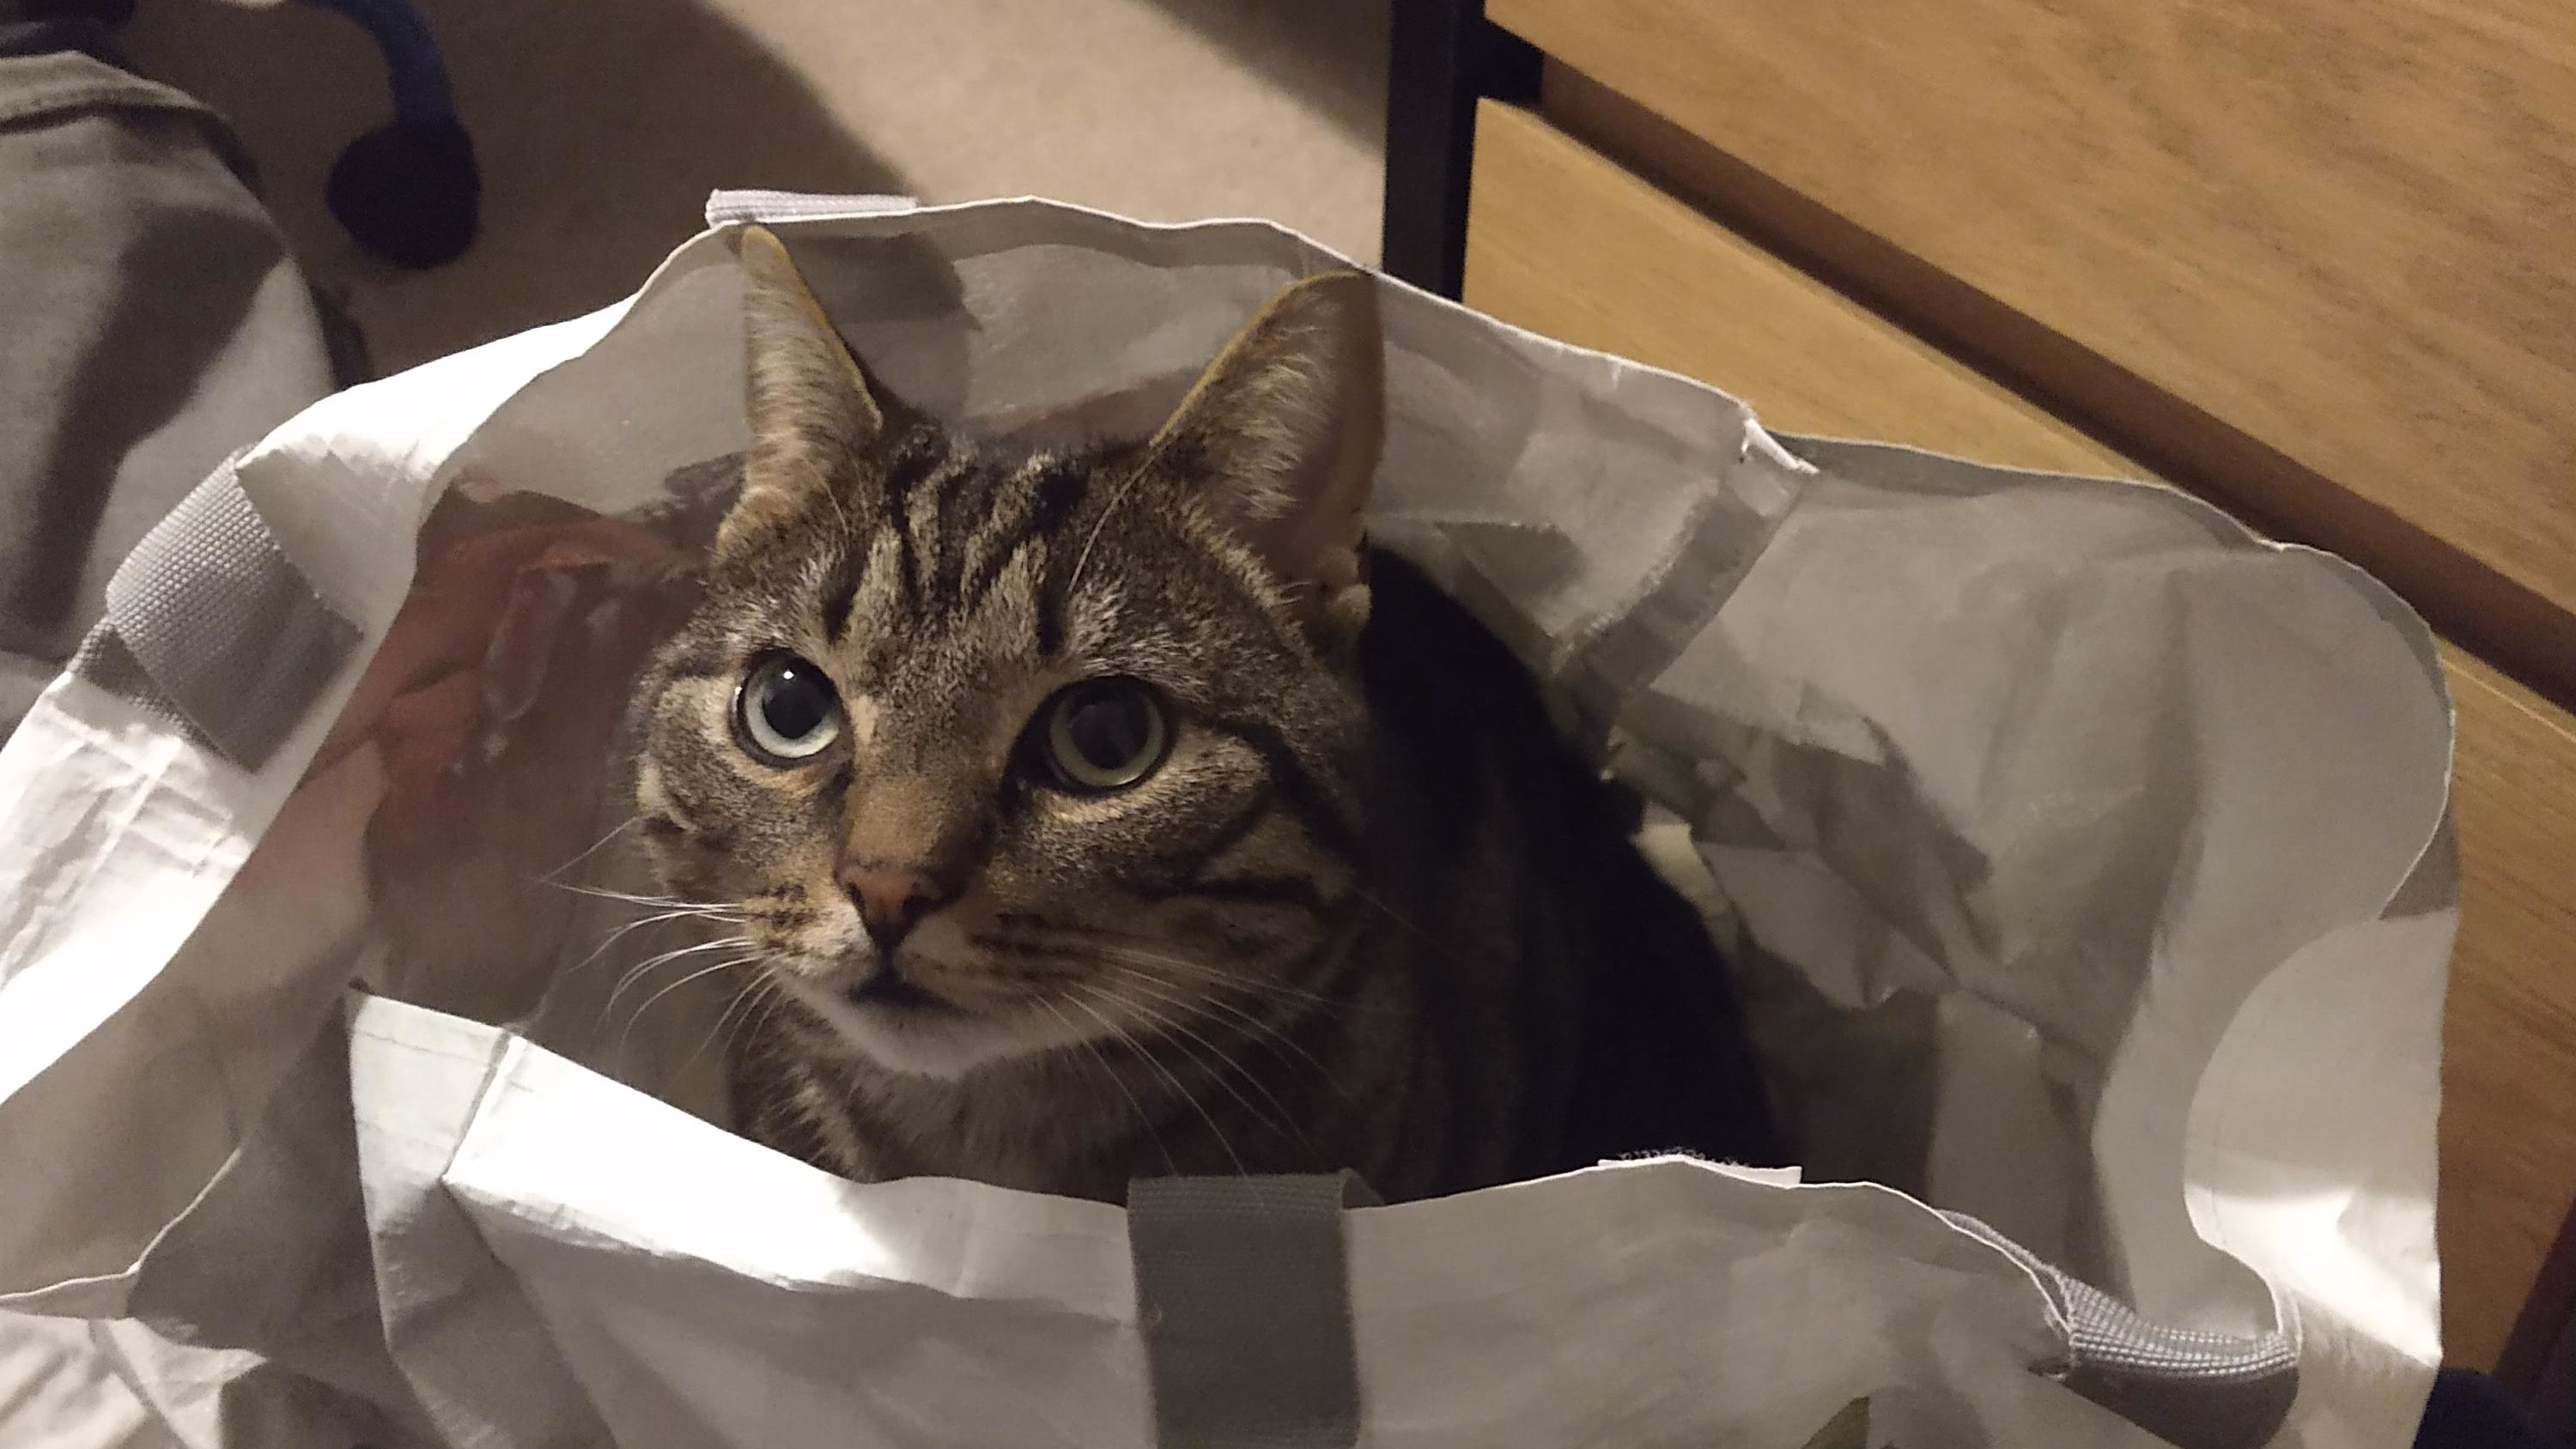

In [3]:
image_raw

Awww. What a beauty.

At this point, we could start doing any software processing we wish to do on `image_raw`. I'll move straight on to the hardware Sobel filter though. We need to think about what format the hardware design expects of our image data. We'll convert the image to something more appropriate for the hardware, send it off, and then receive the processed image.

## Formatting the image for hardware

The sobel filter example has some expectations about the image data:

  * The image should be 1920x1080 pixels
  * Each pixel should be 32 bits
    + 8 bits for red
    + 8 bits for green
    + 8 bits for blue
    + and the remaining 8 bits are unused --- they are only there to pad the pixel out to 32 bits (the natural width of the AXI interface we're using between the PS and PL)
  * The image should then be padded to have one extra pixel all the way around the image's circumference. This is to allow local filtering to be done all the way to the extremes of the original image.
    
Now we'll try to meet this specification using `numpy` arrays.

First we resize the image and ensure it is using the RGB colour system (as opposed to greyscale or luminance–chrominance formats). Next we package the image data into a `numpy` array. We opt to use a 3D array of bytes for this, where an element can be accessed by `image[x][y][colour_component]`. Finally, we pad the X and Y dimensions with 1 extra pixel at either side.

Note that the we will still need to include the 8-bit padding per pixel before sending it to the PL. We're keeping it in this format so we can easily display the image from Python.

In [4]:
IMG_SIZE = (1920,1080)

# Resize and force to RGB colours
image = image_raw.resize(IMG_SIZE).convert('RGB')

# Interpret as a 3D array of bytes (uint8)
image_array = np.array(image, dtype=np.uint8)

# Add extra padding on the X and Y dimensions
image_array_padded = np.pad(image_array, ((1,1),(1,1),(0,0)), 'symmetric')

Again, let's see if we can display the image. This should check that our conversions haven't done anything awful to the image, although the extra 1 pixel padding will be hard to see! We're now coming from a `numpy` array, rather than a JPG file, so we will use the `Image.fromarray` function.

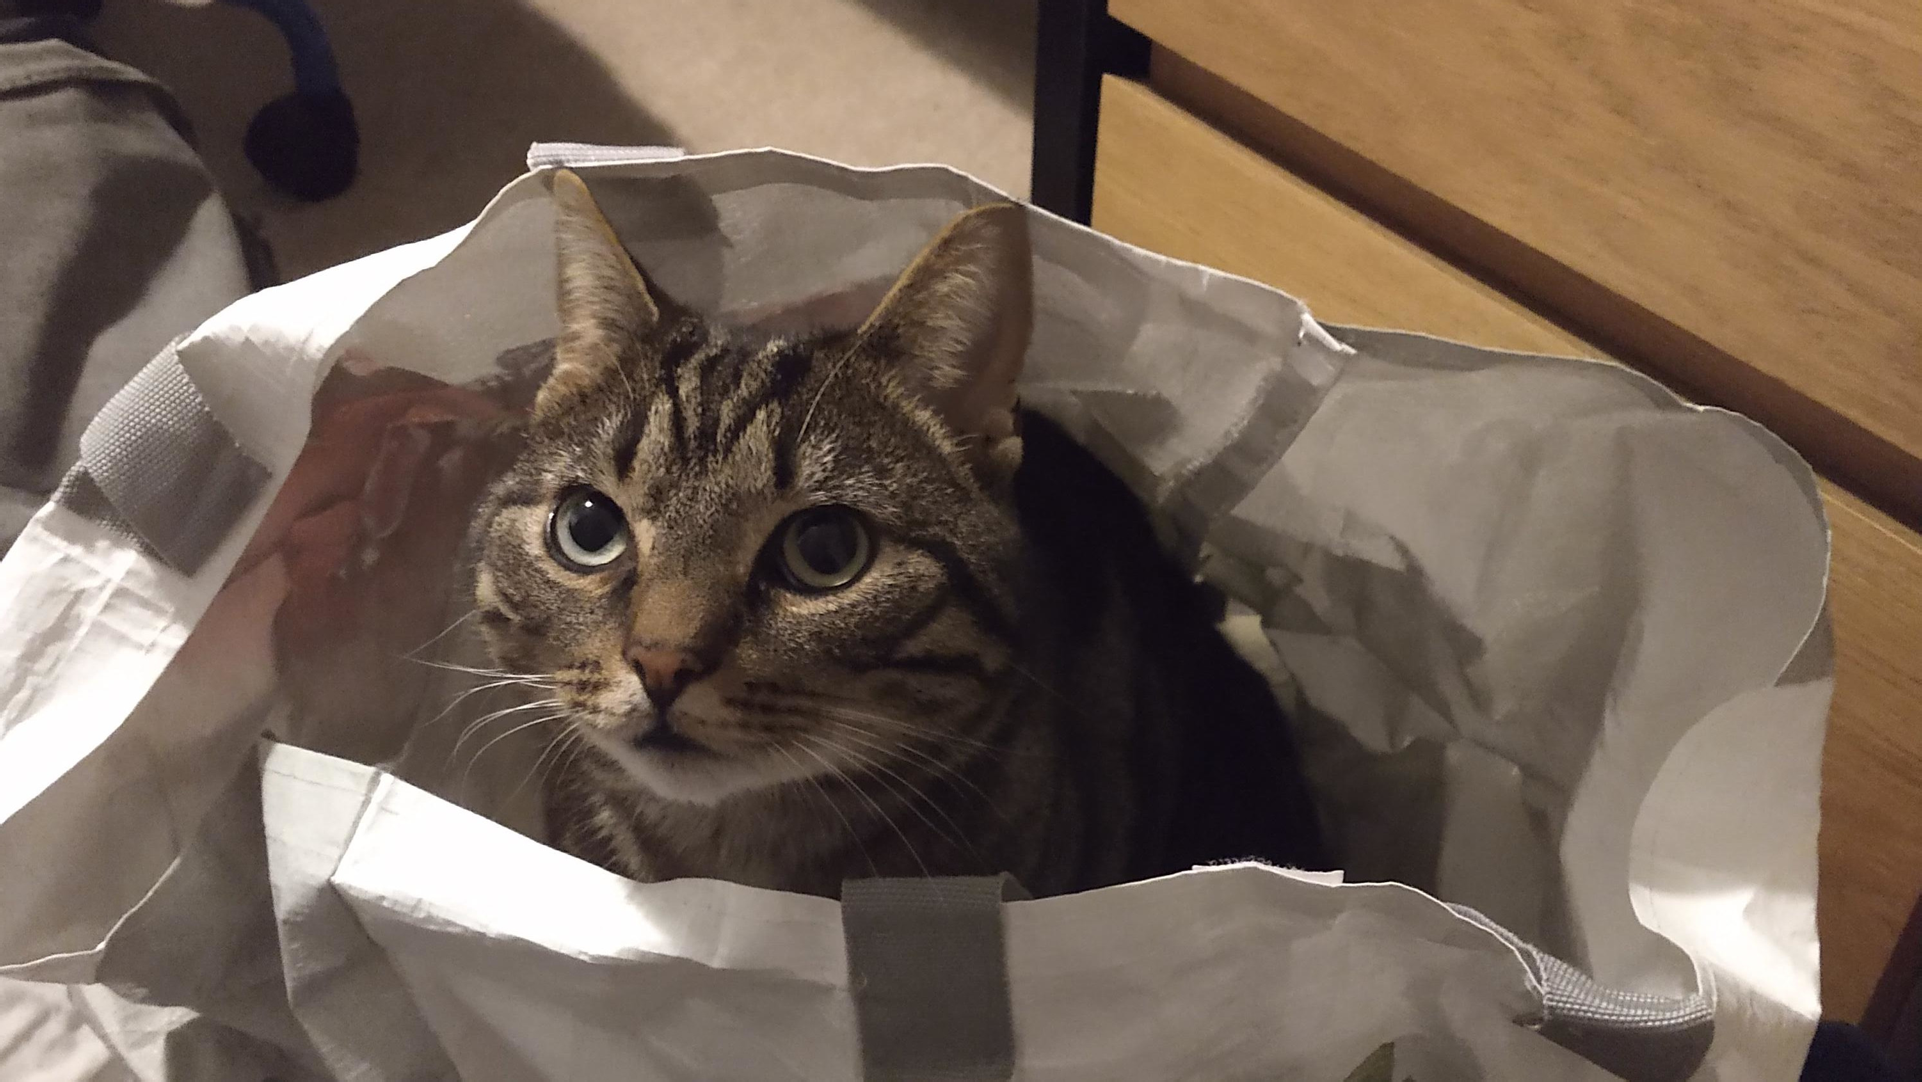

In [5]:
Image.fromarray(image_array_padded, 'RGB')

Good! We're now ready to talk to the hardware Sobel filter.

## Communicating with the hardware Sobel filter

Let's start by importing some libraries and downloading the bitstream:

  * PYNQ's Overlay to load the hardware sobel filter bitstream onto the PL
  * PYNQ's allocate to create buffers suitable for streaming to IP in the PL
    + As an aside, these buffers essentially `numpy` arrays that are contiguous in the physical address space... Is direct control of the physical memory something you *should* be allowed to do from a web browser, you ask? Probably not, if you ask me 🤷‍♂️.

In [20]:
from pynq import Overlay
from pynq import allocate
#import pynq_sobel
import os

#bitstream = os.path.join(os.path.dirname(pynq_sobel.__file__), 'pynq_sobel', 'bitstream', 'pynq_sobel.bit')
overlay = Overlay("Sharpen_wrapper.bit")

Let's get PYNQ to report the names of the IP cores it has detected in this overlay.

In [21]:
overlay?

The pop-up window should report at least 2 IPs: `axi_dma, sobel_filter`. If these IP core names do not match then go back and compare your IP Integrator design with the screenshot at the top of the notebook.

Let's now reserve buffers of the correct size for one input image (with padding) and one output image (without padding). We model the input image as a 3 dimensional array again, but this time we expand the last dimension from a size of 3 (R, G, or B) to 4. This introduces a space for the 8 bit padding required to ensure every pixel aligns to 32 bit boundaries.

The output of the Sobel filter is black and white, so there is no need for multiple colour channels. Because of this, the output buffer is just a 2D array.

Note that we only have to allocate these buffers once. We can reuse the same buffers as much as we need, and this will give us substantially better performance than reallocating buffers every time.

In [22]:
# Input array for DMA use
in_dma_array  = allocate(shape=(IMG_SIZE[1]+2, IMG_SIZE[0]+2, 4), dtype=np.uint8)

# Output array for DMA use
out_dma_array = allocate(shape=(IMG_SIZE[1],IMG_SIZE[0]), dtype=np.uint32)

Let's define a function to take an image (as a `numpy` array), a threshold value, and then return the image that has been processed by the PL.

The Sobel filter has one AXI (memory-mapped) register that we can use to set the threshold. We can write to this register using the IP's `.write(...)` method.

We'll need to copy the image array into one of the (physically contiguous) DMA buffers we have allocated above before streaming it. Then we can use PYNQ's DMA `transfer(..)` and `wait(...)` functions to stream data to and from the Sobel filter IP.

In [23]:
def do_sobel(image_array, thresh=30):

    # Set overlay threshold
   # overlay.axi_stream_sobel_fil_0.write(0, thresh)
    
    # Copy image array into dma buffer
    in_dma_array[:, :, :3] = image_array[:, :, :]
       
    # Perform DMA transfers in both directions
    overlay.axi_dma.recvchannel.transfer(out_dma_array)
    overlay.axi_dma.sendchannel.transfer(in_dma_array)
    overlay.axi_dma.sendchannel.wait()
    overlay.axi_dma.recvchannel.wait()
    
    # Return processed image array from PL 
    return out_dma_array

That ran quickly?!

This is because we have defined the function, but we haven't actually executed it yet 😅
Let's try to run the `do_sobel(...)` function now...

In [24]:
%time image_output = do_sobel(image_array_padded)

CPU times: user 290 ms, sys: 9.33 ms, total: 300 ms
Wall time: 315 ms


And finally, let's display the output image. We do much the same as before, but the image is greyscale now, rather than RGB. To account for this, we change the `Image.fromarray(...)` mode from `RGB` to `P` (see the [documentation](https://pillow.readthedocs.io/en/5.1.x/reference/Image.html) for mode details).

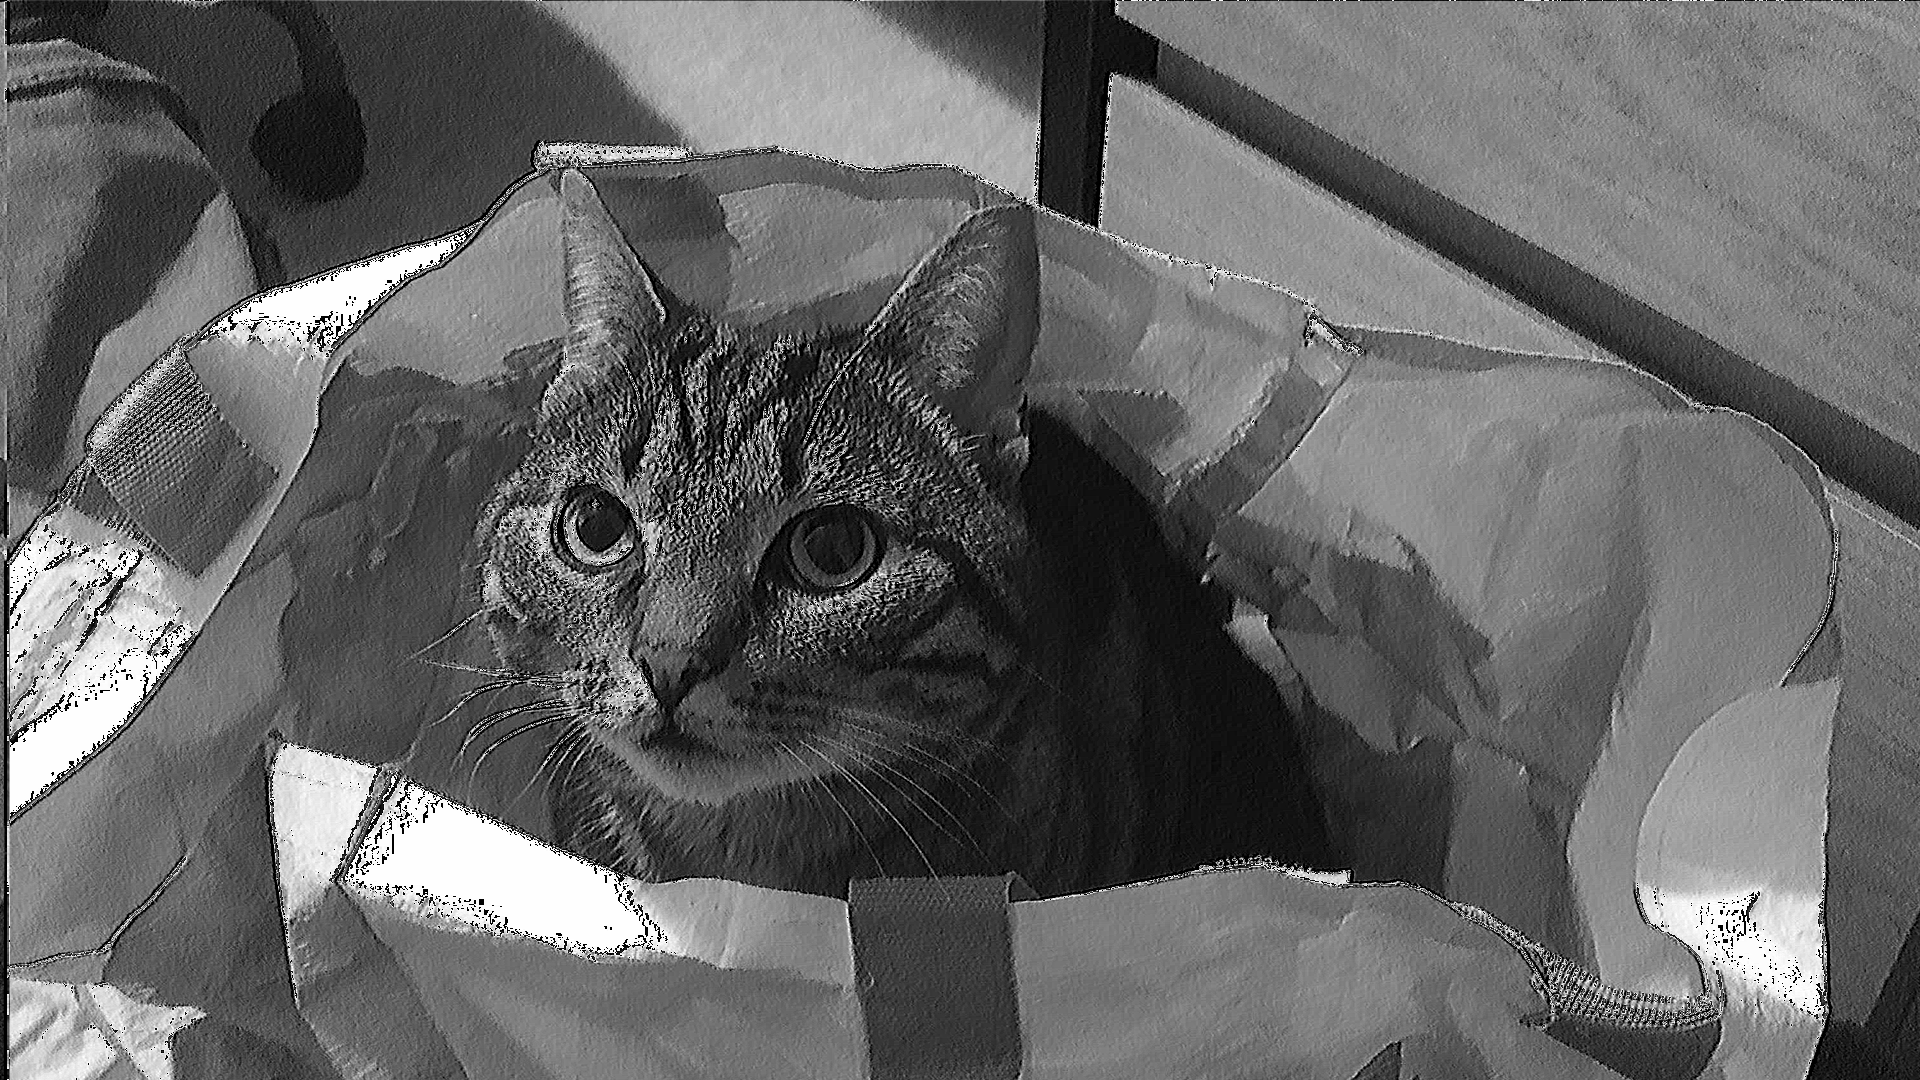

In [25]:
Image.fromarray(np.uint8(image_output), mode='P')

## Comparison with OpenCV
We can compare the speed of the hardware accelerated Sobel filter with an equivalent software model. OpenCV is a useful image processing and computer vision library that contains a Sobel Filter method. Let's call that method now and measure the execution time.

In [ ]:
import cv2

def do_sobel_opencv(image, thresh=30):
    gray = np.array(image.convert('L'))
    grad_x = cv2.Sobel(gray, cv2.CV_32F, 1, 0)
    grad_y = cv2.Sobel(gray, cv2.CV_32F, 0, 1)
    grad = np.sqrt(grad_x**2 + grad_y**2)
    return (grad * 255 / grad.max()).astype(np.uint8) > thresh

In [ ]:
%time opencv_output = do_sobel_opencv(image)

As you can see, the OpenCV implementation of the Sobel Filter executes slower than the hardware accelerated design on the FPGA. We can print the output for inspection to verify the results.

In [ ]:
Image.fromarray(opencv_output)

## Summary

Just to conclude, we have shown a few different things in this notebook:

  * Handling images in Python
  * Preprocessing images in Python, getting it ready for streaming to the PL
  * Streaming images to and from the PL, and displaying the results
  
This should provide a nice starting point for any of your own explorations in image processing circuits. Enjoy! 🎉